In [1]:
import tensorflow as tf
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt
from live_recording import Record

In [2]:
model = models.load_model('Model')
# model.summary()

In [3]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([8000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=64)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

## Prediction on Raw data

In [21]:
def predict_live():
    raw_data = b''
    classes=['Human', 'Noise']
    sample_file = Record('Sample').recording()[1]
    for d in sample_file:
        raw_data+=d
    audio = tf.io.decode_raw(raw_data, tf.uint16)
    print(type(audio))
    print('decoded shape:', audio.shape)
    _spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(_spectrogram, -1)
    spectrogram = tf.expand_dims(spectrogram, 0)
    # np.argmax(model.predict(spectrogram), axis=1)
    print(spectrogram.shape)
    pred = model(spectrogram)
    cls = np.argmax(tf.nn.softmax(pred[0]))
    print(cls)
    output = 'Human' if cls==0 else 'Noise'
    print(output)
    if output=='Human':
        plt.bar(classes, tf.nn.softmax(pred[0]))
    else:
        plt.bar(classes, tf.nn.softmax(pred[0]), color='r')
        
    plt.title(f'Predicted "{output}"')
    plt.show()

Recording
Finished recording
Sample_0107211625254214.wav
<class 'tensorflow.python.framework.ops.EagerTensor'>
decoded shape: (7168,)
(1, 122, 129, 1)
0
Human


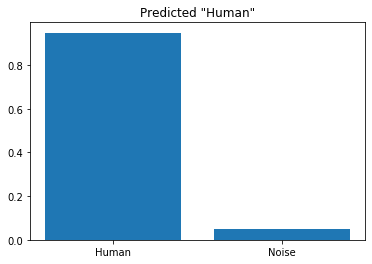

In [36]:
predict_live()

## Prediction on wav file

In [ ]:
def predict_live():
    classes=['Human', 'Noise']
    sample_file = 'Sample_3006211625443149.wav' #Record('Sample').recording()[0]
    audio_binary = tf.io.read_file(sample_file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    _audio = tf.squeeze(audio, axis=-1)
    _spectrogram = get_spectrogram(_audio)
    spectrogram = tf.expand_dims(_spectrogram, -1)
    spectrogram = tf.expand_dims(spectrogram, 0)
    # np.argmax(model.predict(spectrogram), axis=1)
    print(spectrogram.shape)
    pred = model(spectrogram)
    cls = np.argmax(tf.nn.softmax(pred[0]))
    output = 'Human' if cls==0 else 'Noise'
    print(output)
    if output=='Human':
        plt.bar(classes, tf.nn.softmax(pred[0]))
    else:
        plt.bar(classes, tf.nn.softmax(pred[0]), color='r')
       
    plt.title(f'Predicted "{output}"')
    plt.show()

In [ ]:
predict_live()

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [ ]:
sample_file = 'Sample_2906211625376042.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()